# Signed Graph Network Analysis

## Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

## Analysis

### A)

In [2]:
# Import the weighted graph using the specified nodes in the first and second columns. The weight is specified in the third column. 
# Generate an adjacency matrix and save it to an Excel file.

In [3]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)
graph_df

,source,target,weight,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


In [7]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
print("Shape of the adjacency matrix: ", adjacency_matrix.shape)

#save to excel file
adjacency_df = pd.DataFrame(adjacency_matrix)

#adjacency_df.to_excel("data/adjacency_matrix.csv", index=False) -> incredibly slow, therefore chose to save as csv
adjacency_df.to_csv("data/adjacency_matrix.csv", index=False, header=False)

Shape of the adjacency matrix:  (3783, 3783)


### B)

In [10]:
# Using NetworkX, plot the in/out-degree distribution
# and fit the power-law distribution. Use curve fitting and
# confidence bounds of the curve fit library and evaluate
# if the power law distribution can be fit with 80%
# confidence. Additionally, calculate the average clustering
# coefficient and diameter.

In [23]:
def calculate_degrees(degree_dict):
    degree_sequence = sorted([d for n, d in degree_dict], reverse=True)
    degree_count = {}
    for degree in degree_sequence:
        if degree in degree_count:
            degree_count[degree] += 1
        else:
            degree_count[degree] = 1
    return zip(*degree_count.items())

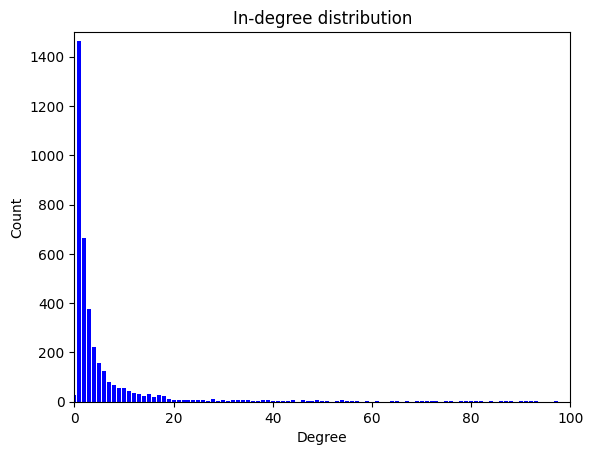

In [30]:
degree, count = calculate_degrees(G.in_degree())
plt.bar(degree, count, color='b')
plt.title("In-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.ylim(0, 1500)
plt.savefig("plots/B_in_degree_distribution.pdf")
plt.show()

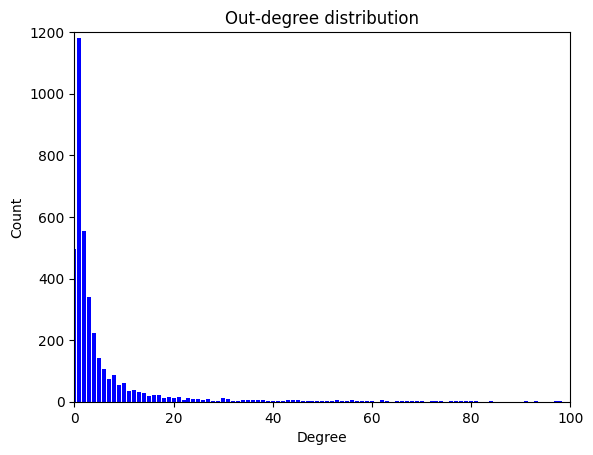

In [29]:
degree, count = calculate_degrees(G.out_degree())
plt.bar(degree, count, color='b')
plt.title("Out-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.ylim(0, 1200)
plt.savefig("plots/B_out_degree_distribution.pdf")
plt.show()

In [31]:
# Use curve fitting and
# confidence bounds of the curve fit library and evaluate
# if the power law distribution can be fit with 80%
# confidence

from scipy.optimize import curve_fit
from scipy.stats import powerlaw



